# AMAL // Prise en main de PyTorch
                        notebook n°3 sur 3

Nous allons créer pour la première fois une structure classique, un autoencodeur,  
puis voir ce qu'il en est pour une architecture "état de l'art" - le Highway Network.  
C'est l'occasion de terminer l'exploration de PyTorch avec l'usage de `DataLoader`, du checkpointing, et le passage sur GPU.

https://pytorch.org/tutorials/beginner/nn_tutorial.html  
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798  
https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/  
https://arxiv.org/abs/1505.00387  
https://towardsdatascience.com/review-highway-networks-gating-function-to-highway-image-classification-5a33833797b5  
https://paperswithcode.com/method/highway-network

In [1]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <useful libraries> ////

# Ne pas oublier d'executer dans le shell avant de lancer python :
# source /users/Enseignants/piwowarski/venv/amal/3.7/bin/activate

from datamaestro import prepare_dataset
from pathlib import Path
import torch
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm.auto import tqdm

# /////////////////////////////////////////////////////////////////////////////////////////////// </useful libraries> ////

### Table des matières

<a href="#load">Utiliser un DataLoader</a>  
<a href="#chck">Checkpointing</a>  
<a href="#auto">Autoencodeurs</a>  
<a href="#expe">Campagne d'expériences</a>  
&nbsp;&nbsp;Dimensions d'encodage // Usage du GPU  
<a href="#high">Bonus : Highway Networks</a>     
&nbsp;&nbsp;Explications // Implémentation // Résultats pour 784 dimensions // Impact d'un subsampling

### Utilisation de DataLoader <a id='load'></a>

Aujourd'hui, nous entraînons notre modèle sur la base MNIST, qui comprend 70000 éléments (dont 60000 en train).

Un `DataLoader` permet d'éviter de charger toutes les données en mémoire à chaque itération.  
On en choisit à chaque fois le strict nécessaire, et on libère immédiatement l'espace. Sans cela, la taille des bases de données serait un obstacle important.  

In [2]:
# ///////////////////////////////////////////////////////////////////////////////////////////////// <collecting data> ////

class handleDataset(Dataset) :
    def __init__(self, X, Y):
        self.data = torch.from_numpy(X.copy()/255).float()
        self.data = self.data.view(self.data.shape[0],-1)
        self.etiq = torch.from_numpy(Y.copy()).float()
        self.lngt = len(self.etiq)
    
    def __getitem__(self, index):
        return self.data[index], self.etiq[index]
    
    def __len__(self) :
        return self.lngt
    
ds = prepare_dataset("com.lecun.mnist");
train_images, train_labels = ds.train.images.data(), ds.train.labels.data()
test_images, test_labels =  ds.test.images.data(), ds.test.labels.data()
sbatch = 128
trainMNIST = DataLoader(handleDataset(train_images,train_labels),shuffle=True,batch_size=sbatch)
testMNIST = DataLoader(handleDataset(test_images,test_labels),shuffle=True,batch_size=sbatch)
print("\nTrain/test split done, size of the training set is", train_images.shape[0])
print("Size of the testing set is",test_images.shape[0])

# //////////////////////////////////////////////////////////////////////////////////////////////// </collecting data> ////


Train/test split done, size of the training set is 60000
Size of the testing set is 10000


### Checkpointing <a id='chck'></a>

PyTorch permet de reprendre l'apprentissage là où il s'est arrêté (pour une raison quelconque). Pour cela, il faut retenir l'état courant du modèle, ce qui se fait avec la classe ci-dessous :

In [3]:
# ////////////////////////////////////////////////////////////////////////////////////// <checkpointing on the model> ////

class State(object) :
    def __init__(self, model, optim):
        self.model = model
        self.optim = optim
        self.epoch, self.iteration = 0, 0
        
# ///////////////////////////////////////////////////////////////////////////////////// </checkpointing on the model> ////

### Autoencodeurs <a id='auto'></a>

Un Autoencodeur est un réseau de neurones dont le nombre de couches est libre, tant qu'elles sont symétriques. Il est composé d'un encodeur (phase 1) et d'un décodeur (phase 2).  
En phase 1 d'une itération, il représente une entrée sous une forme sous-dimensionnée (dimension latente). En phase 2 de la même itération, il la décode en suivant la même logique pour lui rendre ses dimensions originelles. Cela lui permet de vérifier son résultat et de pénaliser les compressions jugées incorrectes en fonction de la distance (loss) entre l'original et la proposition décodée.  

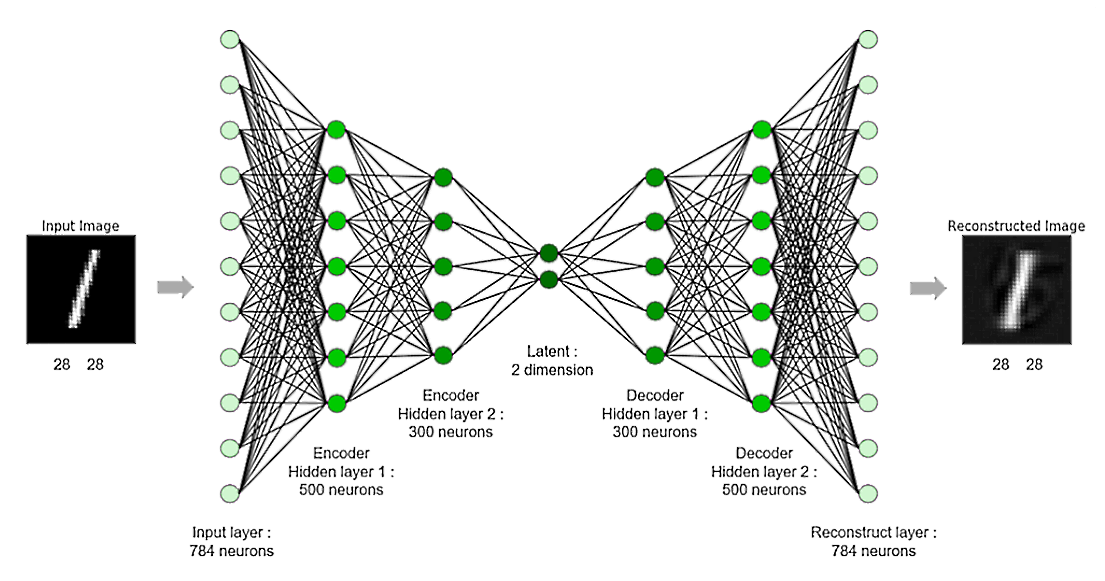

L'idéal serait que la sortie encodée puis décodée corresponde exactement à l'entrée. C'est l'objectif de l'apprentissage.

In [4]:
# /////////////////////////////////////////////////////////////////////////////////////////////// <basic autoencoder> ////

class AutoEncoder(torch.nn.Module):
    def __init__(self, x, chosendim):
        # Declaring layers and activation functions
        super(AutoEncoder,self).__init__()
        self.dimorigin = x.shape[1]*x.shape[2]
        # Chosen latent dimension
        self.dimlatent = chosendim
        # Encoding
        self.linenc = torch.nn.Linear(self.dimorigin, self.dimlatent) # Phase 1
        self.actenc = torch.nn.ReLU()
        # Decoding
        self.lindec = torch.nn.Linear(self.dimlatent, self.dimorigin) # Phase 2
        self.actdec = torch.nn.Sigmoid()

    def encodeMe(self,x):
        # Forward movement, phase 1: make a compressed representation
        encoded = self.actenc(self.linenc(x))
        return encoded
        
    def decodeMe(self,encoder):
        # Forward movement, phase 2: reconstruct a full-dimensional image
        self.lindec.weight = torch.nn.Parameter(self.linenc.weight.t())
        decoded = self.actdec(self.lindec(encoder))
        return decoded
            
    def forward(self,x):
        # Merge both movements
        encoded = self.encodeMe(x)
        return self.decodeMe(encoded)
    
# ////////////////////////////////////////////////////////////////////////////////////////////// </basic autoencoder> ////

Cet autoencodeur maison n'a qu'une couche interne.  
On applique donc seulement une transformation linéaire `H = f(X,W,b)` + une activation à une entrée `X` (phase 1) ;  
on obtient une sortie `Y` en réappliquant `f(H,W.T,b')` et une seconde activation (phase 2).

Le fait d'utiliser la transposée des poids de la phase 1 dans la phase 2 permet d'apprendre des paramètres cohérents.  
L'objectif de cette architecture est de caractériser la justesse de la compression en sortie de phase 1 ; il ne faudrait donc surtout pas que les poids de la phase 2 "corrigent" quoi que ce soit et soient la raison du succès de l'apprentissage.   
**La sortie de l'encodeur doit être bonne, à elle seule, à résumer l'information d'une façon qui permette de la retrouver en entier.  
Il faut donc faire en sorte que seul son paramétrage compte.**

<span style="color:gray">Par contre, les biais appliqués b et b' ne peuvent pas être identiques ni transposés pour des raisons de dimensions...</span>

### Campagne d'expériences <a id='expe'></a>

Les objectifs sont multiples.
- Comparer les résultats de l'encodage/décodage pour plusieurs dimensions latentes (justesse, temps écoulé)
- Mettre en oeuvre le checkpointing, car l'apprentissage prend du temps
- Constater l'amélioration induite par l'usage du GPU

In [5]:
# ////////////////////////////////////////////////////////////////////////////////////////////////////// <test phase> ////

writer = SummaryWriter("runs")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Trying various encoding dimensions
for latent in [32,64,128,256]:
    
    print("\n//////////////////////////////////// Trying "+str(latent)+"-dims encoding ///////////////////////////////////////\n")
    
    # Creating a checkpointed model for each
    savepath = Path("model"+str(latent)+".pch")
    if savepath.is_file():
        print("Restarting from previous state.")
        with savepath.open( "rb" ) as fp :
            state = torch.load(fp)
    else:
        auto = AutoEncoder(train_images,latent)
        auto = auto.to(device)
        epsilon = 0.0005
        # Binary cross-entropy
        loss = torch.nn.BCELoss()
        optim = torch.optim.Adam(auto.parameters(),lr=epsilon)
        state = State(auto, optim)

    # Training it on 50 epochs - although convergence is reached before
    # (see the plots below for proof)
    for epoch in tqdm(range(state.epoch,50)):
        for x,y in trainMNIST:
            state.optim.zero_grad()
            x = x.to(device)
            xhat = auto(x.float())
            ltrain = loss(xhat,x.float())
            ltrain.backward()
            state.optim.step()
            state.iteration += 1
        # Testing current parameters
        for x,y in testMNIST:
            with torch.no_grad():
                x = x.to(device)
                xhat = auto(x.float())
                ltest = loss(xhat.float(),x.float())
        # Showing the outputs at various stages
        if epoch==1 or epoch == 10 or epoch == 42:
            orig = make_grid((x[0:5]).clone().detach().view(5,28,28).unsqueeze(1).repeat(1,3,1,1).float())
            writer.add_image(f'originals/'+str(latent)+'/'+str(epoch), orig, epoch)
            preds = make_grid((xhat[0:5]).clone().detach().view(5,28,28).unsqueeze(1).repeat(1,3,1,1).float())
            writer.add_image(f'predictions/'+str(latent)+'/'+str(epoch), preds, epoch)

        # Saving the losses
        writer.add_scalars('Loss/AutoEncoder/'+str(latent),{'train':ltrain,'test':ltest}, epoch)
        # Saving the current state after each epoch
        with savepath.open ("wb") as fp:
            state.epoch = epoch+1
            torch.save(state, fp)
    
    print("\033[92mDone.\033[0m\n")

# ///////////////////////////////////////////////////////////////////////////////////////////////////// </test phase> ////


//////////////////////////////////// Trying 32-dims encoding ///////////////////////////////////////

Restarting from previous state.



Done.


//////////////////////////////////// Trying 64-dims encoding ///////////////////////////////////////

Restarting from previous state.



Done.


//////////////////////////////////// Trying 128-dims encoding ///////////////////////////////////////

Restarting from previous state.



Done.


//////////////////////////////////// Trying 256-dims encoding ///////////////////////////////////////

Restarting from previous state.



Done.



##### Comparaison de plusieurs dimensions d'encodage

Nous avons lancé ce modèle avec 32,64,128 puis 256 dimensions.

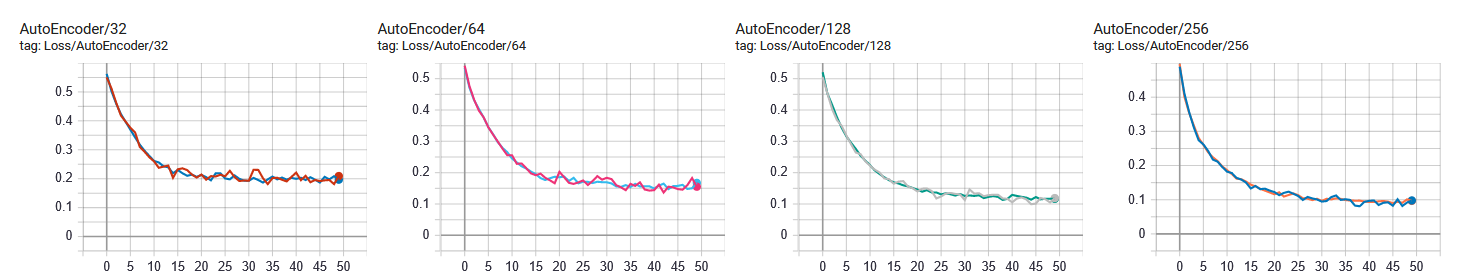

**La forme générale des courbes de loss reste la même.**  
La mise à jour est d'abord très efficace, mais on atteint ensuite un plateau après la vingtième epoch. La convergence est donc plutôt rapide. Cependant, la loss reste plutôt élevée : cela veut dire qu'on ne peut pas faire mieux avec ces réglages.  
L'apprentissage en train et en test suit exactement la même dynamique dans tous les cas. Les loss train et test sont superposées (quasi-égales) pour chaque modèle, ce qui veut dire que l'encodage appris sur le train est bien valable sur toute la base.  
Les légères imperfections (systématiquement plus présentes en test, courbes resp. rouge, rose, grise et bleue) sont dues à la descente de type minibatch qu'assure le DataLoader.

**Quel est donc l'impact de la dimension latente ?**  
Augmenter la dimension latente permet une meilleure reconstruction à la sortie de l'autoencodeur, avec une loss de plus en plus faible au niveau de la même itération. On termine au bout de 50 epochs avec une convergence à ~0.2 pour dimlatente = 32 contre ~0.1 pour dim = 256.  

**Est-ce utile ?** tout dépend de l'usage.

De fait, l'output du modèle dim = 32 n'est pas satisfaisant après 50 epochs ; mais celui pour dim = 64 est visuellement très reconnaissable.  
Ci-dessous, une charte montrant les originaux et les sorties de l'autoencodeur à l'itération 1, 10 et 42 dans chaque cas :

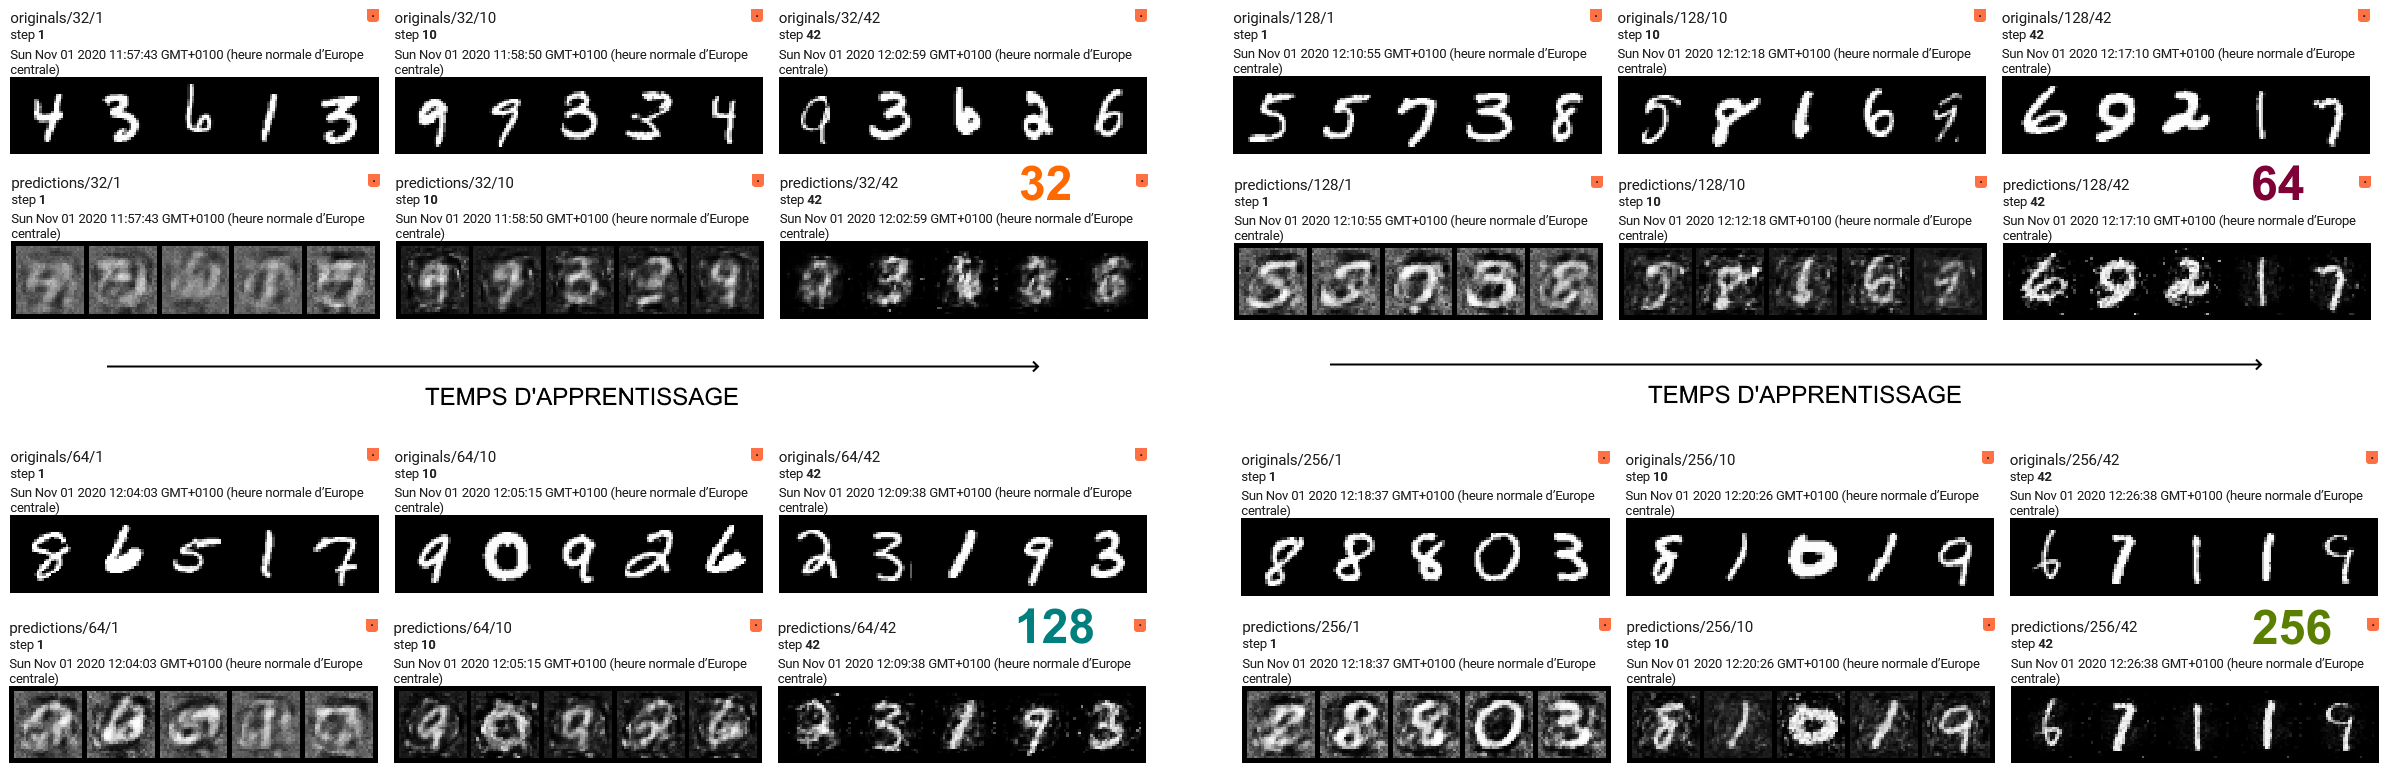

On constate par contre qu'il ne faut que 10 itérations avec dim = 256 (en bas à droite) pour obtenir un résultat quasi-parfait. Cela prend quatre fois plus (42 itérations) avec dim = 64. 

**Pour choisir entre dim = 64 et dim = 256, il faut donc voir si la ressource limitante est le temps mis ou l'espace mémoire utilisé pour la représentation latente des résultats.**

##### Utilisation du GPU

Avec le CPU d'une machine puissante, l'apprentissage prend environ deux minutes pour chaque dimension (apprentissage complet sans reprise en checkpoint). La sortie de `tqdm` (la retrouver ci-dessus) a servi à faire les mesures.

<span style="color:gray">Toujours pour un calcul sur le CPU, on remarquera des dynamiques différentes selon la machine, avec le même code.  
Sur l'une, une itération est plus courte lorsque la représentation latente a plus de dimensions : probablement parce que la réduction à faire par rapport à l'original est plus facile.  
Sur une autre, l'apprentissage est plus rapide lorsque la représentation a moins de dimensions. Il doit s'agir d'une autre gestion de la mémoire ?</span>

Sur la même machine, passer en GPU permet d'économiser encore plus de temps : 

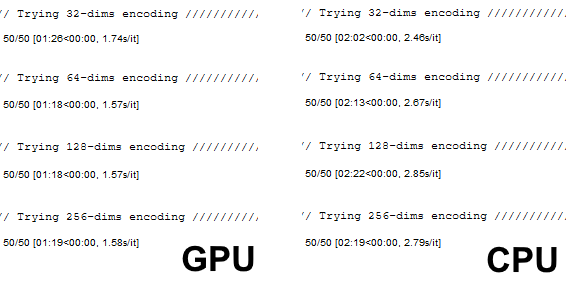

Le temps total de calcul est réduit entre 30 et 55% selon les cas. On utilise donc de préférence un GPU lorsqu'il est disponible.

### Highway Network <a id='high'></a>

On passe sans transition à un tout autre type de réseau.

##### Explications

Un Highway Network comporte des modules qui combattent l'évanouissement du gradient, courant dans les réseaux profonds, en passant l'information issue des couches précédentes en avant. L'entraînement d'un tel modèle requiert presque systématiquement un GPU.

Ce type de réseau est décrit dans un article du 3 novembre 2015 (joyeux anniversaire !) : 
https://arxiv.org/abs/1505.00387  
L'output y de chaque couche vaut

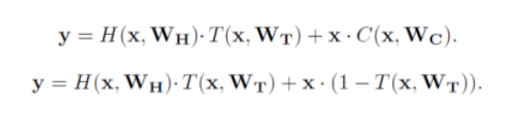

Les transformations $T$ et $1-T$ (où $T$ s'appelle *Transform*, et $1-T = C$ *Carry*) sont des "gates", des portes à activation sigmoide - à valeurs entre 0 et 1. Ces structures servent à décider si l'on fait passer ou non une information, et si oui avec quel poids, en se posant comme multiplicateurs de cette information.

Chaque couche utilise ces deux types de portes $T$ et $C$ pour régler deux flux :
- Sa porte *Transform* s'applique à $H(x)$, soit ce qu'elle vient de calculer. Cet $H(x)$ serait tout simplement la sortie pour un réseau classique ; mais sur un Highway Network, il peut peser moins de 100% dans cette sortie. La porte *Transform* sert justement à réguler précisément ce pourcentage.  
- Sa porte *Carry* s'applique directement à l'input initial $x$ et régule son passage (potentiellement direct si $C=1$ !) vers la sortie.

Comme les valeurs totales des sigmoïdes $T$ et $C$ somment à 1 ($C = 1-T$), il s'agira en fait de composer linéairement l'output de chaque couche avec ces deux éléments. **Par somme avec le résultat de la porte *Transform*, on peut donc dire que la porte *Carry* complète l'output classique de chaque couche avec une réminiscence de l'input qu'elle a reçu.**

L'idée de ces unités "porte" qui régulent le flux de données n'est pas nouvelle - on la connaissait dans les LSTM (1995). Mais le réseau que nous entraînons ici n'est pas un RNN. C'est donc une transposition du concept.

##### Implémentation

En regardant le code associé à l'article sur arXiv, on tombe assez facilement sur plusieurs versions.  
On reprend la base publiée sur 
https://github.com/kefirski/pytorch_Highway/blob/70b75db7a2d029f4bbe08fd4c7d69e36bf7b6d3a/highway/highway.py

In [6]:
# ///////////////////////////////////////////////////////////////////////////////////////////////// <highway network> ////

class HighwayNetwork(torch.nn.Module):

    def __init__(self, num_layers, data = None, size=None):
        super(HighwayNetwork, self).__init__()
        # Retrieves the layers' sizes either from the data... 
        if data and not size:
            size = data.shape[1]*data.shape[2]
        # ...or from explicit parametering...
        if size and not data:
            # Make as many layers as asked, 
            # with one linear transformation, one activation function, and one gate
            self.num_layers = num_layers
            self.nonlinear = torch.nn.ModuleList([torch.nn.Linear(size,size) for _ in range(num_layers)])
            self.linear = torch.nn.ModuleList([torch.nn.Linear(size,size) for _ in range(num_layers)])
            self.gate = torch.nn.ModuleList([torch.nn.Linear(size,size) for _ in range(num_layers)])
        else:
            # ...or maybe it still doesn't know
            print("How many neurons am I supposed to create?")

    def forward(self, x):
        for layer in range(self.num_layers):
            gate = torch.sigmoid(self.gate[layer](x))
            nonlinear = torch.nn.functional.relu(self.nonlinear[layer](x))
            linear = self.linear[layer](x)
            x = gate * nonlinear + (1-gate) * linear
        return x

# //////////////////////////////////////////////////////////////////////////////////////////////// </highway network> ////

**Comment choisir les hyperparamètres ?  
L'un d'entre eux est la taille et la composition des couches.**  
Combien de couches faut-il ? Le choix est à nous. Nous essaierons plusieurs possibilités.  
Avec combien de neurones faut-il les peupler ? Il faut avoir lu l'article, qu'on cite :

> L'équation (3) [celle expliquée ci-dessus] requiert que la dimensionalité de $x$, $y$, $H(x,WH)$ et $T(x,WT)$ soit la même. Dans les cas où il est désirable de changer la taille de la représentation, il est possible de remplacer $x$ avec $\hat{x}$ qui serait obtenu avec un subsampling ou un zero-padding.  
Une autre alternative est d'utiliser une couche simple (sans unités Highway) en entrée pour changer la dimensionalité, et de continuer en empilant des couches Highway. C'est l'alternative que nous choisissons dans cette étude.

En un mot, les couches Highway ont nécessairement des entrées et des sorties de même taille.  
Pour notre réseau, on commence donc par utiliser la taille réelle des images MNIST (soit 784 dimensions...) sur toutes. Mais garder autant de dimensions au départ est idiot, surtout que notre autoencodeur parvenait à représenter presque toute l'information avec bien moins.  
Nous essaierons donc ultérieurement un subsampling à l'entrée pour en voir l'effet.

**L'autre hyperparamètre est le pas d'apprentissage.** Le nombre de tentatives étant limité par le temps, nous préférons la sécurité, et nous le choisissons très petit (10e-5) - quitte à devoir faire tourner l'algorithme un peu plus longtemps pour assurer une convergence.

In [7]:
# ////////////////////////////////////////////////////////////////////////////////////////////////////// <test phase> ////

writer = SummaryWriter("runs/Highway")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epsilon=0.00001
# Trying various layer numbers
for layers in [2,5,10]:
    print("\n//////////////////////////////////// Trying "+str(layers)+" layers ///////////////////////////////////////\n")
    
    # Creating a checkpointed model for each
    savepath = Path("model"+str(layers)+".pch")
    if savepath.is_file():
        print("Restarting from previous state.")
        with savepath.open( "rb" ) as fp :
            state = torch.load(fp)
    else:
        high = HighwayNetwork(train_images,num_layers=layers)
        high = high.double().to(device)
        loss = torch.nn.CrossEntropyLoss()
        optim = torch.optim.Adam(high.parameters(),lr=epsilon)
        state = State(high,optim)

    # Training it on 100 epochs
    for epoch in tqdm(range(state.epoch,100)):
        for x,y in trainMNIST:
            state.optim.zero_grad()
            x = x.double().to(device)
            y = y.double().to(device)
            xhat = high(x.double())
            ltrain = loss(xhat.double(),y.long())
            ltrain.backward()
            state.optim.step()
            state.iteration += 1
            
        # Testing current parameters
        for x,y in testMNIST:
            with torch.no_grad():
                x = x.double().to(device)
                y = y.double().to(device)
                xhat = high(x.double())
                ltest = loss(xhat.double(),y.long())
        # Saving the losses
        writer.add_scalars('Loss/HighwayNetwork/'+str(layers),{'train':ltrain,'test':ltest}, epoch)
        # Saving the current state after each epoch
        with savepath.open ("wb") as fp:
            state.epoch = epoch+1
            torch.save(state, fp)
    
    print("\033[92mDone.\033[0m\n")

# ///////////////////////////////////////////////////////////////////////////////////////////////////// </test phase> ////


//////////////////////////////////// Trying 2 layers ///////////////////////////////////////

Restarting from previous state.



Done.


//////////////////////////////////// Trying 5 layers ///////////////////////////////////////

Restarting from previous state.



Done.


//////////////////////////////////// Trying 10 layers ///////////////////////////////////////

Restarting from previous state.



Done.



Il était inimaginable d'entraîner un modèle à 10 couches sur un CPU, à cause du temps : 

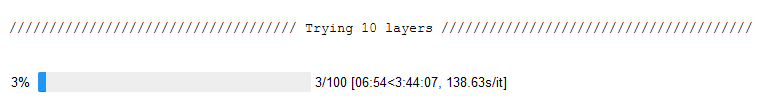

##### Résultats pour 784 dimensions

Voici les graphes résultat pour deux, cinq et dix couches. L'apprentissage se fait bien avec des loss qui diminuent amplement.
A noter que comme dans le TME2, multiplier le nombre de couches à autres paramètres égaux augmente la loss finale (elle vaut ~0.2 pour dix couches, ~0.1 pour moins).

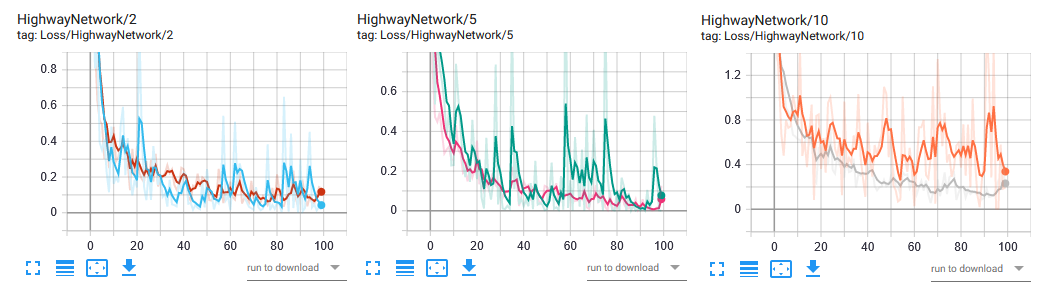

Pour les trois tailles de réseau, on reste quand même sur un apprentissage un peu chaotique.  
La longueur de cet apprentissage nous empêche de mener beaucoup plus d'expériences. On préfère explorer l'idée ci-dessous.

##### Expérimentation sur un subsampling

L'autoencodeur plus haut peut facilement servir à diminuer les 784 dimensions. Si on récupère la sortie de la phase 1 seule, elle a plus ou moins l'effet d'une PCA. On décide donc de ramener les données à 128 dimensions avant d'entraîner le Highway Net (pour dim=128, on se souvient que la reconstruction était bonne).  
Avoir 128 neurones par couche au lieu de 784 permet d'avoir des couches beaucoup plus petites - et donc un entraînement plus facile et plus rapide sur de plus grandes profondeurs.

<span style="color:gray">Note : il va suffire d'entraîner l'encodeur sur le dataset train pour l'appliquer ensuite partout. De fait, rappel, la proximité des courbes en train et en test affichées plus haut montrait que l'encodage était exportable à la partie test des données.</span>

In [27]:
# /////////////////////////////////////////////////////////////////////////////////////////// <training the Encoder> ////

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
auto = AutoEncoder(train_images,128)
auto = auto.to(device)
epsilon = 0.0005
loss = torch.nn.BCELoss()
optim = torch.optim.Adam(auto.parameters(),lr=epsilon)

print("\n/////////////////////////////// Starting to learn 128-dim representations. ///////////////////////////////\n")
for epoch in tqdm(range(60)):
    for x,_ in trainMNIST:
        optim.zero_grad()
        x = x.to(device)
        xhat = auto(x.float())
        ltrain = loss(xhat,x.float())
        ltrain.backward()
        optim.step()

print("\033[92mDone.\033[0m\n")

# ////////////////////////////////////////////////////////////////////////////////////////// </training the Encoder> ////


/////////////////////////////// Starting to learn 128-dim representations. ///////////////////////////////




Done.



In [28]:
# ///////////////////////////////////////////////////////////////////////////////////////////// <encoding the data> ////

toreducetrain = handleDataset(train_images,train_labels)
toreducetest = handleDataset(test_images,test_labels)

# Apply the encoding
toreducetrain.data = toreducetrain.data.to(device)
toreducetest.data = toreducetest.data.to(device)
reducedtrain = auto.encodeMe(toreducetrain.data)
reducedtest = auto.encodeMe(toreducetest.data)

# Change the handling mode (could have used PyTorch's methods as well)
class otherDataset(Dataset) :
    def __init__(self, data, etiq):
        # better detach and clone, or else -
        # it will retain_graph() for everything we did before !
        self.data = data.detach().clone() 
        self.etiq = etiq.detach().clone()
        self.lngt = len(self.etiq)

    def __getitem__(self, index):
        return self.data[index], self.etiq[index]

    def __len__(self):
        return self.lngt
    
# Use in a DataLoader
trainred = DataLoader(otherDataset(reducedtrain,toreducetrain.etiq),shuffle=True,batch_size=sbatch)
testred = DataLoader(otherDataset(reducedtest,toreducetest.etiq),shuffle=True,batch_size=sbatch)

# //////////////////////////////////////////////////////////////////////////////////////////// </encoding the data > ////

In [31]:
# ///////////////////////////////////////////////////////////////////////////////////////////////////// <test phase> ////

writer = SummaryWriter("runs/Highway")
epsilon=10e-6

print("\n//////////////////////////////////// Trying 20 layers + subsampling ///////////////////////////////////////\n")

# Creating a checkpointed model
savepath = Path("model20.pch")
if savepath.is_file():
    print("Restarting from previous state.")
    with savepath.open( "rb" ) as fp :
        state = torch.load(fp)
else:
    high = HighwayNetwork(num_layers=20,size=128)
    high = high.double().to(device)
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(high.parameters(),lr=epsilon)
    state = State(high,optim)

# Training it on 30 epochs
for epoch in tqdm(range(state.epoch,30)):
    for x,y in trainred:
        state.optim.zero_grad()
        x = x.double().to(device)
        y = y.double().to(device)
        xhat = high(x.double())
        ltrain = loss(xhat.double(),y.long())
        ltrain.backward()
        state.optim.step()
        state.iteration += 1
    # Testing current parameters
    for x,y in testred:
        with torch.no_grad():
            x = x.double().to(device)
            y = y.double().to(device)
            xhat = high(x.double())
            ltest = loss(xhat.double(),y.long())

    # Saving the losses
    writer.add_scalars('Loss/HighwayNetwork/20',{'train':ltrain,'test':ltest}, epoch)
    # Saving the current state after each epoch
    with savepath.open ("wb") as fp:
        state.epoch = epoch+1
        torch.save(state, fp)

print("\033[92mDone.\033[0m\n")

# //////////////////////////////////////////////////////////////////////////////////////////////////// </test phase> ////


//////////////////////////////////// Trying 20 layers + subsampling ///////////////////////////////////////




Done.



L'apprentissage a très bien commencé. La loss est descendue immédiatement, plus vite que pour les versions à 784 dimensions.  Cependant, elle a connu une remontée ; le pas de gradient valait alors 10e-5, et ce phénomène poussait à choisir plus petit par sécurité.   
On a fourni une illustration ci-dessous, sur le graphique de gauche.  

La loss a diminué plus lentement et très proprement pour un pas de 10e-6 (graphique de droite) sans qu'on ait le temps d'observer ce genre de remontées ; un apprentissage plus long aurait sûrement été profitable.

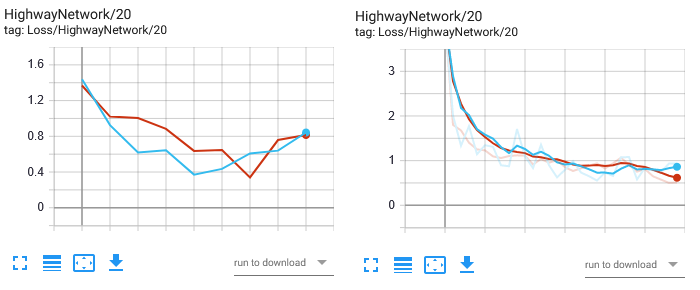

**Le deuxième graphique est la preuve que l'apprentissage *peut se faire* avec plus de couches et beaucoup moins de dimensions. Reste qu'il manque l'optimisation : d'autres paramètres auraient rendu ce résultat beaucoup plus intéressant.**

### Conclusions 

De toutes les façons, l'entraînement d'un Highway Network profond était-il justifiable sur MNIST ?  
MNIST reste une petite base, assez simple, et les performances dessus sont déjà assez bonnes avec des réseaux classiques. Ce n'est pas là que les Highway Networks doivent faire leurs preuves, car la profondeur n'est pas un grand avantage ici.
On prend donc ce qu'on vient de faire comme un exercice.

Des pistes supplémentaires sur ce TME incluent l'augmentation des couches de l'Autoencodeur, à essayer,
ainsi que la mise en place d'autres initialisations sur les Highway. On avait expliqué en long et en large dans le TME2 que l'initialisation Xavier était essentielle sur des réseaux profonds ; c'est peut-être la clef pour tout améliorer.